# Estratégia de Long & Short com Cointegração
Este projeto pretende demonstrar a teoria e aplicação da estratégia de trading **Long & Short** (*Pairs Trading*) com **cointegração**.
Apesar de fazer um abordagem inicial e simplista, será apresentadado os fatores relavantes para a detecção de pares para a aplicação da estratégia, e um algoritimo para validação e backingtest nos ativos do IBOV, servindo como uma introdução para inciantes.

![](Pairs_trading/images/Pairs_Trading.png)

Este projeto está dividido em:
- Base teórica.
- Implementação.
- Resultados.

# Base Teórica

A estratégia de **Pairs Trading** (também conhecida como **Long and Short**) é uma abordagem de investimento amplamente utilizada no mercado financeiro. Consiste em identificar ativos cujos preços estejam relacionados e operar com base no diferencial entre eles.

A ideia central é encontrar pares de ativos que historicamente apresentam uma relação de preço estável. Ao observar desvios dessa relação, realiza-se uma operação assumindo uma posição **long** (compra) no ativo subvalorizado e uma posição **short** (venda) no ativo sobrevalorizado, esperando que os preços retornem à sua relação histórica.

Simplificando, busca-se identificar ativos cujos preços tendem a subir e descer na mesma proporção, mantendo uma distância constante entre si. Quando ocorrem divergências e essa distância está significativamente acima da média histórica, é possível arbitrar comprando e vendendo a diferença até que ocorra o retorno à média esperada.

![Cointegração](images/Cointegração.png)

Neste projeto, será testada a seleção de pares por **Cointegração**. No entanto, existem outras abordagens, como o uso de cópulas e diferenças.

A cointegração entre duas séries ocorre quando ambas compartilham uma mesma tendência estocástica:

$$
\begin{align}
Pa_{t} = \mu_0 + \beta_0 Pb_t + \epsilon_{0t} \\
\text{e} \\
Pb_{t} = \mu_1 + \beta_1 Pa_t + \epsilon_{1t}
\end{align}
$$

Onde:

- $Pa_t$: Preço do ativo A no tempo t
- $Pb_t$: Preço do ativo B no tempo t
- $\mu$: Valor de equilíbrio entre os ativos
- $\epsilon_t$: Variável aleatória estocástica $\mathcal{N}(0,1)$, o termo de erro que não é previsível.

Como $\mu_0$ e $\mu_1$ são aleatórios, temos que:

$$
Pa_{t} + \beta Pb_t = \mu + \epsilon_{t}
$$

Pode-se estimar uma das séries por meio de uma regressão linear da outra, na forma:

$$
Pa_{t} = \mu + \epsilon_{t} - \beta Pb_t
$$

Sendo $Pa$ o ativo dependente e $Pb$ o independente.

O erro dessa regressão pode ser escrito como:

$$
\epsilon_t = Pa_{t} - \mu - \beta Pb_t
$$

Nesse formato, se as séries forem **cointegradas** e o modelo de regressão for estável, $\epsilon$ deverá ser uma série **estacionária**.

Uma série temporal é estacionária quando suas características estatísticas (média, variância, autocorrelação) são constantes ao longo do tempo. É uma série que evolui aleatoriamente em torno da sua média e com equilíbrio estatístico estável (as leis de probabilidade que atuam no processo não mudam com o tempo).

Além da estacionariedade, para a cointegração, a relação entre os ativos deve ser estável, mesmo se for trocado o ativo dependente pelo independente.

Na estratégia aplicada, foi realizada, entre cada par de ativos possível nos componentes do IBOV, uma regressão linear utilizando o método **TLS** (Mínimos Quadrados Total - Total Least Squares), que aproxima uma reta minimizando as distâncias totais entre os valores da série estimada.

![Regressão TLS](Pairs_trading/images/TLS_regression.png)

Diferentemente da regressão linear por **OLS** (Mínimos Quadrados Ordinários), mais conhecida, a regressão linear por **TLS** apresenta um coeficiente linear equivalente mesmo se os ativos dependentes e independentes forem trocados.

Para verificar a condição de estacionariedade dos resíduos da estimação entre os ativos, foi aplicado o teste de **Dickey-Fuller Aumentado (ADF)**, que verifica a presença de uma raiz unitária em uma série temporal, indicando se ela é não estacionária. Este teste avalia se há evidências estatísticas de que a série possui uma tendência ou ciclo que não se dissipa ao longo do tempo. <br><br>

### Referências:

- [Pairs Trading Definition](https://www.investopedia.com/terms/p/pairstrade.asp)
- [Statistical Arbitrage Pairs: Can Cointegration Capture Market Neutral Profits?](https://openaccess.nhh.no/nhh-xmlui/bitstream/handle/11250/169897/hoel2013.pdf?sequence=1)
- [An Introduction to Total Least Squares](https://arxiv.org/pdf/math/9805076)


## Implementação

A estratégia segue os seguintes passos:

### 1. Regressão Linear com **TLS**  
- Realiza-se uma regressão linear utilizando o método **TLS** (Mínimos Quadrados Total - Total Least Squares) para todos os pares de ações do IBOV.  

### 2. Validação da Cointegração  
- Valida-se a **Cointegração** entre os pares por meio do teste **ADF** (Augmented Dickey-Fuller).  
- Apenas os pares que resultarem em resíduos estacionários são selecionados para os passos seguintes.  

### 3. Cálculo do **Z-Score** dos Resíduos  
- Para os pares cointegrados, calcula-se o **Z-Score** dos resíduos, referido como **Spread** a partir deste ponto.  
    - O **Z-Score** representa a normalização dos resíduos em termos de desvios-padrão, indicando o afastamento da média.  

### 4. Definição de Sinais de Entrada e Saída  
- Os sinais de entrada e saída são definidos com base no **Z-Score**:  
    - Uma posição é aberta quando:  
        - $\epsilon_t \leq -1.5$: Venda do **Spread** (long).  
        - $\epsilon_t \geq 1.5$: Compra do **Spread** (short).  
    - As posições são encerradas sempre que o **Spread** retornar à média.  

- A abertura de posição funciona da seguinte forma:  
    - **Compra do Spread**: Compra do ativo A e venda do ativo B na proporção $A = \beta B$.  
    - **Venda do Spread**: Venda do ativo A e compra do ativo B na mesma proporção.

Para garantir a proporção correta entre os ativos na operação, os pesos são calculados da seguinte forma:

$$
W_{A_t} = \frac{Pa_t}{Pa_t + \beta Pb_t}
$$

$$
W_{B_t} = \frac{\beta Pb_t}{Pa_t + \beta Pb_t}
$$

Onde:

- $W_{A_t}$: Peso do ativo A no momento do sinal de entrada.
- $W_{B_t}$: Peso do ativo B no momento do sinal de entrada.
- $Pa_t$: Preço do ativo A no momento do sinal de entrada.
- $Pb_t$: Preço do ativo B no momento do sinal de entrada.
- $\beta$: Coeficiente estimado na regressão linear entre os dois ativos.

Esses pesos garantem que a proporção relativa entre os ativos seja mantida conforme a relação definida pela regressão linear. Assim, a operação reflete corretamente o diferencial entre os preços dos ativos.  


De forma simplificada, quando o **Spread** atinge 1.5 desvios-padrão abaixo da média, abre-se uma posição comprada no ativo A (dependente na regressão linear) e vendida no ativo B (independente na regressão linear).  
Isso ocorre porque o **Spread** tende a retornar à média. Assim, quando o ativo A valoriza ou desvaloriza em relação ao ativo B, cria-se uma oportunidade de arbitragem e lucro.

![](Pairs_trading/images/Pairs_Trading.png)

#### Dados de Entrada  
- Utilizam-se os preços de fechamento dos componentes do IBOV no período de **01/01/2015 a 01/11/2024**.  
- Os dados são divididos em:  
    - **Treinamento (In-Sample)**: Para calibrar a estratégia.  
    - **Teste (Out-of-Sample)**: Para validar o desempenho fora da amostra usada no treinamento.  


In [33]:
# Importando bibliotecas necessárias
import pandas as pd
import yfinance as yf
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

In [14]:
# Definindo funções auxiliares

# Função paa a regressão linear por TLS
from sklearn.metrics import r2_score
import numpy as np
class TLS:
    X = []
    Y = []
    def __init__(self, X, Y):
        # Armazena X e Y como atributos
        self.index = X.index
        self.X = np.asarray(X)
        self.Y = np.asarray(Y)
        self.beta = None
        self.intercept = None
        # Realiza o ajuste do modelo ao inicializar
        #self.fit()

    
        # Monta a matriz com as variáveis
        A = np.vstack((self.X, self.Y)).T
        
        # Centraliza a matriz
        mean_X, mean_Y = np.mean(self.X), np.mean(self.Y)
        A_centered = A - np.array([mean_X, mean_Y])
        
        # Realiza a SVD
        _, _, Vt = np.linalg.svd(A_centered)
        
        # Calcula beta e intercept a partir da SVD
        V = Vt.T
        self.beta = -V[0, 1] / V[0, 0]
        self.intercept = mean_Y - self.beta * mean_X

    def predict(self):
        # Predição com o modelo ajustado
        return self.beta * self.X

    def residuals(self):
        # Calcula os erros residuais usando as variáveis armazenadas
        predictions = self.predict()
        residuals = self.Y - predictions
        return residuals
    
    def r_squared(self):
        # Calcula o R² da predição
        predictions = self.predict()
        r_2 = r2_score(self.Y,predictions)
        return r_2

# Seleção dos pares de ativos
from statsmodels.tsa.stattools import adfuller
def fn_pairs_selection(data,tolerance,R_squared=0.7):
    pair_tickers = {}
    pairs = []
    result_adf = []
    r_squareds = []
    spread_pair = {}
    beta_pair = {}
    tickers = data.columns
    count = 0
    n_pares = 0
    for i in (range(0,len(tickers))):
        j = i+1
        for j in range(j,len(tickers[i:])):
                X = data[tickers[i]]
                Y = data[tickers[j]]
                model = TLS(X,Y)
                residuals = model.residuals()
                r_2 = model.r_squared()
                result = adfuller(residuals) 
                count +=1
                if abs(result[1]) < tolerance and r_2 >= R_squared:
                    print(f'Par Cointegrado: {tickers[i]} e {tickers[j]} | Tolerance: {result[1]} | R² = {np.round(r_2,4)}')
                    tag = tickers[i]+'-'+tickers[j]
                    pairs.append(tag)
                    pair_tickers[tag] = ([tickers[i],tickers[j]])
                    spread_pair[tag] = residuals
                    beta_pair[tag] = model.beta
                    result_adf.append(result[1])
                    r_squareds.append(r_2)
                    n_pares += 1
    return pairs, pair_tickers, spread_pair , beta_pair, result_adf, r_squareds, count,n_pares

# Calcula o spread entre os ativos com a função TLS
def fn_calc_spread(data,pairs,pair_tickers):
    spread_pair = {}
    for pair in tqdm(pairs):
        X = data[pair_tickers[pair][0]]
        Y = data[pair_tickers[pair][1]]
        model = TLS(X,Y)
        residuals = model.residuals()
        spread_pair[pair] = residuals
    return  spread_pair

def fn_adf_result(serie):
    result = adfuller(serie) 
    # Exibindo os resultados
    print("Estatística ADF")
    print("Estatística ADF:", result[0])
    print("Valor-p:", result[1])
    print("Valores Críticos:")
    for key, value in result[4].items():
    	print(f" {key}: {value}")
    if result[1] < 0.05:
    	    print("A série é estacionária (rejeitamos a hipótese nula).")
    else:
    	    print("A série NÃO é estacionária (não rejeitamos a hipótese nula).")
    

# Cálcula o Z Score para cada Spread
def fn_calc_z_scores(df_series):
    resids_mean = np.mean(df_series)
    std_dev = np.std(df_series)
    z_scores = (df_series - resids_mean)/  std_dev
    return z_scores


Coleta de dados

In [55]:
ibov= pd.read_csv("IBOV.csv",encoding='windows-1252',
                    skiprows=0,delimiter=';',decimal=',')
START = '2015-01-01'
END = '2024-11-01'

TICKERS = ibov['Codigo'].dropna().values
TICKERS.sort()
df_bruto = pd.DataFrame()
# Baixando os dados de fechamento
for ticker in tqdm(TICKERS):
    try:
        # Baixando os preços ajustados
        price_ticker = yf.download((str(ticker)+'.SA'), start=START, end=END, progress=False)['Adj Close']
        # Verificando se os dados estão disponíveis
        if not price_ticker.empty:  # Pula se estiver vazio
            df_bruto = pd.concat([df_bruto, price_ticker], axis=1)
        else:
            print(f"Sem dados para o ticker {ticker}, pulando.")
    except Exception as e:
        print(f"Erro ao baixar dados para {ticker}: {e}")



  3%|▎         | 3/86 [00:00<00:21,  3.90it/s]
1 Failed download:
['ARZZ3.SA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-01-01 -> 2024-11-01) (Yahoo error = "No data found, symbol may be delisted")')
  5%|▍         | 4/86 [00:02<00:57,  1.42it/s]

Sem dados para o ticker ARZZ3, pulando.


 10%|█         | 9/86 [00:03<00:31,  2.43it/s]
1 Failed download:
['BBDC4.SA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-01-01 -> 2024-11-01)')
 12%|█▏        | 10/86 [00:05<00:55,  1.36it/s]

Sem dados para o ticker BBDC4, pulando.


 20%|█▉        | 17/86 [00:08<00:25,  2.70it/s]
1 Failed download:
['CIEL3.SA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-01-01 -> 2024-11-01) (Yahoo error = "No data found, symbol may be delisted")')
 21%|██        | 18/86 [00:09<00:45,  1.50it/s]

Sem dados para o ticker CIEL3, pulando.


 51%|█████     | 44/86 [00:18<00:12,  3.40it/s]
1 Failed download:
['ITSA4.SA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-01-01 -> 2024-11-01)')
 52%|█████▏    | 45/86 [00:19<00:26,  1.57it/s]

Sem dados para o ticker ITSA4, pulando.


 77%|███████▋  | 66/86 [00:26<00:07,  2.84it/s]
1 Failed download:
['RRRP3.SA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-01-01 -> 2024-11-01) (Yahoo error = "No data found, symbol may be delisted")')
 78%|███████▊  | 67/86 [00:28<00:13,  1.39it/s]

Sem dados para o ticker RRRP3, pulando.


 83%|████████▎ | 71/86 [00:29<00:06,  2.32it/s]
1 Failed download:
['SOMA3.SA']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-01-01 -> 2024-11-01) (Yahoo error = "No data found, symbol may be delisted")')
 84%|████████▎ | 72/86 [00:31<00:09,  1.42it/s]

Sem dados para o ticker SOMA3, pulando.


100%|██████████| 86/86 [00:35<00:00,  2.43it/s]


Text(0.5, 1.0, 'Retornos dos ativos do IBOV no período')

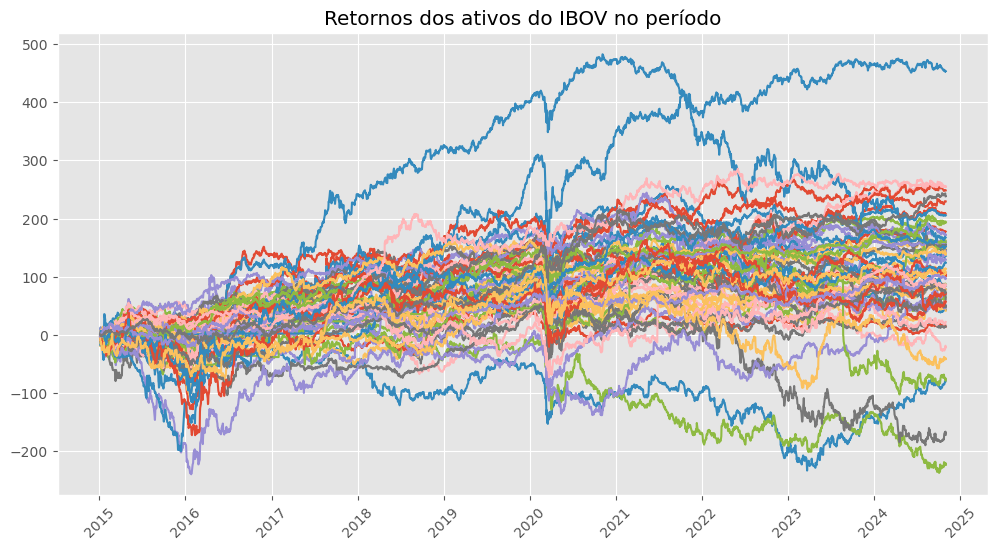

In [56]:
df_prices = df_bruto.copy()
df_prices.columns = df_prices.columns.str.replace('.SA', '', regex=False)
df_prices.dropna(axis=1,inplace=True)
df_prices.dropna(inplace=True)
TICKERS = df_prices.columns
df_rets = np.log(df_prices / df_prices.shift(1))
df_base = df_rets.cumsum().dropna()
plt.figure(figsize=(12,6))
plt.plot(df_base*100)
plt.xticks(rotation=45)
plt.title('Retornos dos ativos do IBOV no período')


Separando dados entre treino e teste
 - Dados de treino entre 2015 e 2019.
 - Dados de teste de 2020 até 2024

In [57]:
train_limit_date = 2019
test_limit_date = 2022
train_data = df_base[df_base.index.year <=train_limit_date]
test_data = df_base[(df_base.index.year >=train_limit_date+1)]

train_data_price = df_prices[df_prices.index.year <=train_limit_date].iloc[0:]
test_data_price = df_prices[(df_prices.index.year >= train_limit_date+1)].iloc[0:]

Seleção de pares e cálculo do spread

In [58]:
pairs_tag, pair_tickers ,train_spreads, betas, adf_values, r_2_values,n_pares_pos, n_pares = fn_pairs_selection(train_data,tolerance=5/100,R_squared=0.75)
test_spreads = fn_calc_spread(test_data,pairs_tag,pair_tickers)
print('***************************')
print(f'Total de pares Possíveis : {n_pares_pos}')
print(f'Total de pares cointegrados: {n_pares}, igual á {(n_pares/n_pares_pos)*100}%')
df_pares = pd.DataFrame(index=pairs_tag)
df_pares['Betas'] = [beta for beta in betas.values()]
df_pares['ADF_result'] = np.round(adf_values,5)
df_pares['R²'] = np.round(r_2_values,3)
df_pares

Par Cointegrado: ALPA4 e LREN3 | Tolerance: 0.01834759243339954 | R² = 0.9031
Par Cointegrado: ALPA4 e SBSP3 | Tolerance: 0.04922802079486303 | R² = 0.855
Par Cointegrado: B3SA3 e EQTL3 | Tolerance: 0.0011620311048417078 | R² = 0.9266
Par Cointegrado: BBAS3 e BBDC3 | Tolerance: 0.007631124241855701 | R² = 0.9428
Par Cointegrado: BBAS3 e ENGI11 | Tolerance: 0.008627533345374862 | R² = 0.7639
Par Cointegrado: BBAS3 e PETR4 | Tolerance: 0.015408295346678872 | R² = 0.9199
Par Cointegrado: BBDC3 e CPFE3 | Tolerance: 0.026491416886176063 | R² = 0.7503
Par Cointegrado: BBDC3 e ENGI11 | Tolerance: 0.007259499844070569 | R² = 0.8332
Par Cointegrado: BRAP4 e MGLU3 | Tolerance: 0.010978778752974164 | R² = 0.9321
Par Cointegrado: BRAP4 e PETR4 | Tolerance: 0.028264137675146773 | R² = 0.7593
Par Cointegrado: CPFE3 e ELET3 | Tolerance: 0.02334447523620893 | R² = 0.8215
Par Cointegrado: CSNA3 e ELET3 | Tolerance: 0.0016795307380971518 | R² = 0.7569
Par Cointegrado: CYRE3 e DXCO3 | Tolerance: 0.012387

100%|██████████| 14/14 [00:00<00:00, 55.26it/s]

***************************
Total de pares Possíveis : 930
Total de pares cointegrados: 14, igual á 1.5053763440860215%


,Betas,ADF_result,R²
ALPA4-LREN3,0.894036,0.01835,0.903
ALPA4-SBSP3,0.797800,0.04923,0.855
B3SA3-EQTL3,0.788309,0.00116,0.927
BBAS3-BBDC3,0.692498,0.00763,0.943
BBAS3-ENGI11,1.120727,0.00863,0.764
BBAS3-PETR4,1.087828,0.01541,0.920
BBDC3-CPFE3,0.775087,0.02649,0.750
BBDC3-ENGI11,1.637335,0.00726,0.833
BRAP4-MGLU3,2.445033,0.01098,0.932
BRAP4-PETR4,0.623334,0.02826,0.759


In [59]:
# exemplo do resultado do teste ADF
fn_adf_result(train_spreads[pairs_tag[0]])


Estatística ADF
Estatística ADF: -3.2293467023494054
Valor-p: 0.01834759243339954
Valores Críticos:
 1%: -3.435634587707382
 5%: -2.8638736617392837
 10%: -2.568012472034339
A série é estacionária (rejeitamos a hipótese nula).


Calculo dos **z_scores**

In [60]:
z_scores_train = {}
z_scores_test = {}
for tags in tqdm(pairs_tag):
    z_scores_train[tags] = fn_calc_z_scores(train_spreads[tags])
    z_scores_test[tags] = fn_calc_z_scores(test_spreads[tags])


100%|██████████| 14/14 [00:00<00:00, 2957.45it/s]


Exemplo de cotação e Z_Score de par cointegrado

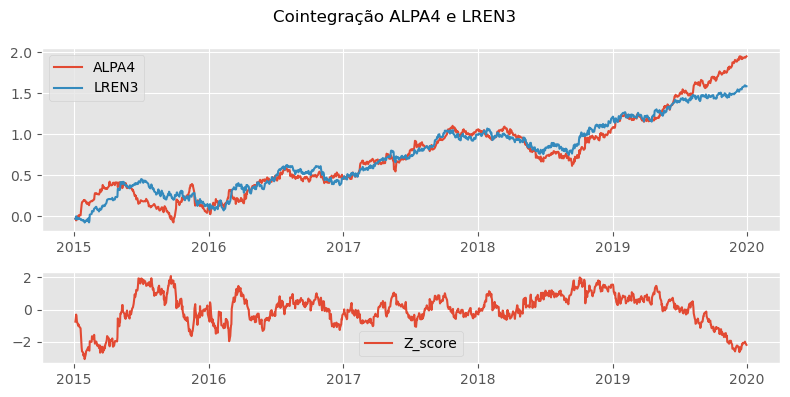

In [61]:
fig = plt.figure(figsize=(8, 4))
grid = fig.add_gridspec(2, 1, height_ratios=[6,3])

ax1 = fig.add_subplot(grid[0,0])

ax1.plot(train_data[pair_tickers[pairs_tag[0]]],label=pair_tickers[pairs_tag[0]])
ax1.legend()

ax2 = fig.add_subplot(grid[1,0])
ax2.plot(train_data[pair_tickers[pairs_tag[0]]].index,z_scores_train[pairs_tag[0]],label='Z_score')
ax2.legend()


plt.suptitle(f'Cointegração {pair_tickers[pairs_tag[0]][0]} e {pair_tickers[pairs_tag[0]][1]}')
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

# Backtesting

A seguir, será implementado um **Backtesting** para os pares selecionados, com o objetivo de avaliar como a estratégia teria se comportado no período analisado.

## Suposições e Simplificações  
As seguintes simplificações serão consideradas:  
- **Isenção de taxas**: Não serão consideradas taxas de corretagem ou impostos.  
- **Preço de execução**: As operações de compra e venda utilizarão os preços de fechamento do dia seguinte à confirmação do sinal de entrada na posição.  
- **Análise individual**: Cada par cointegrado será testado de forma independente.  

### Considerações sobre as simplificações  
Essas simplificações tornam o backtesting menos realista, resultando em uma performance potencialmente superior à que seria observada em condições reais de mercado.  

No entanto, para fins didáticos, essas simplificações são adequadas, pois permitem compreender a dinâmica da estratégia sem comprometer a análise. Ainda assim, para utilização em conta real, é imprescindível realizar um backtest mais realista, incorporando custos operacionais e variações nos preços de execução.  


In [62]:
def fn_pairs_trading(data_price,data_ret,z_scores,caixa,spread_limit,max_day,pct_ordem_a,pct_ordem_b):
    '''
    Estratégia pairs trading
    '''

    # declarando variaveis base para cálculo dos sinais de entrada e saída
    df_pairs = data_ret.copy()
    df_prices = data_price.copy()
    df_ticker_a = data_price.iloc[:,0]
    df_ticker_b = data_price.iloc[:,1]
    df_pairs['z_score'] = z_scores
    banda_sup = spread_limit
    banda_inf = - banda_sup
    signals_line = np.zeros(len(df_pairs))
    posicao_ativa = None
    days_positioning = 0
    max_days = max_day
    
    # declarando variaveis para cálculo do retorno
    profits = np.zeros(len(df_pairs))
    profit_day_a = 0
    profit_day_b = 0
    net_value = np.zeros(len(df_pairs))
    net_value[0] = caixa

    # declarando variaveis para dataframe de analíse das entradas
    signals = []
    price_entry = []
    price_out = []
    entry_date = []
    out_date = []
    max_days_pos = []
    net_position_entry = []
    net_position_out =  []
    

    for i in range(1,len(df_pairs)-1):
        # atualizando sinais
        if posicao_ativa == 'long' or posicao_ativa == 'short':
            days_positioning += 1
            signals_line[i] = signals_line[i-1]
            net_value[i] = ((profits[i] * net_value[i-1]) + net_value[i-1])
        # Sinais de entrada
        if posicao_ativa == None:
            if df_pairs['z_score'].iloc[i-1] < banda_inf and df_pairs['z_score'].iloc[i] > banda_inf:
                signals_line[i] = signals_line[i-1] + 1
                posicao_ativa = 'long'
                
                prices_a = (df_prices.iloc[i+1,0])
                prices_b = (df_prices.iloc[i+1,1])
                Pa = df_ticker_a.iloc[i+1]
                Pb = df_ticker_b.iloc[i+1]
                Wa = (pct_ordem_a*Pa / ((pct_ordem_a*Pa) + (pct_ordem_b * Pb)))
                Wb = ((pct_ordem_b*Pb) / ((pct_ordem_a*Pa) + (pct_ordem_b * Pb)))       

                signals.append('long')
                entry_date.append([df_pairs.index[i+1]])
                price_entry.append([prices_a,prices_b])     
                net_position_entry.append([Pa*Wa,-Pb*Wb])  
            
            elif df_pairs['z_score'].iloc[i-1] > banda_sup and df_pairs['z_score'].iloc[i] < banda_sup:
                signals_line[i] = signals_line[i-1]-1
                posicao_ativa = 'short'
               
                prices_a = (df_prices.iloc[i+1,0])
                prices_b = (df_prices.iloc[i+1,1])
                Pa = df_ticker_a.iloc[i+1]
                Pb = df_ticker_b.iloc[i+1]
                Wa = (pct_ordem_a*Pa / ((pct_ordem_a*Pa) + (pct_ordem_b * Pb)))
                Wb = ((pct_ordem_b*Pb) / ((pct_ordem_a*Pa) + (pct_ordem_b * Pb)))

                signals.append('short')
                entry_date.append([df_pairs.index[i+1]])
                price_entry.append([prices_a,prices_b])
                net_position_entry.append([-Pa*Wa,Pb*Wb])
            
            # Sinais de saída
        elif posicao_ativa == 'long':
            if (df_pairs['z_score'].iloc[i-1] < 0 and df_pairs['z_score'].iloc[i] >= 0) or days_positioning >= max_days:
                signals_line[i] = signals_line[i-1]-1
                posicao_ativa = None

                max_days_pos.append(days_positioning)
                days_positioning = 0
                prices_a = (df_prices.iloc[i,0])
                prices_b = (df_prices.iloc[i,1])

                out_date.append([df_pairs.index[i+1]])
                price_out.append([prices_a,prices_b])
                net_position_out.append([Pa,-Pb])

            # Atualizando lucro do dia
            profit_day_a = np.log(df_prices.iloc[i-1,0] / df_prices.iloc[i,0])
            profit_day_b = np.log(df_prices.iloc[i-1,1] / df_prices.iloc[i,1])
            profit_day = profit_day_a * Wa - profit_day_b * Wb
            profits[i] = profit_day

        else:
            if df_pairs['z_score'].iloc[i-1] > 0 and df_pairs['z_score'].iloc[i] <= 0 or days_positioning >= max_days:
                signals_line[i] = signals_line[i-1]+1
                posicao_ativa = None
                
                max_days_pos.append(days_positioning)
                days_positioning = 0
                prices_a = (df_prices.iloc[i,0])
                prices_b = (df_prices.iloc[i,1])
                
            
                out_date.append([df_pairs.index[i+1]])
                price_out.append([prices_a,prices_b])
                net_position_out.append([-Pa,Pb])

            # Atualizando lucro do dia    
            profit_day_a = np.log(df_prices.iloc[i-1,0] / df_prices.iloc[i,0])
            profit_day_b = np.log(df_prices.iloc[i-1,1] / df_prices.iloc[i,1])
            profit_day = - profit_day_a * Wa + profit_day_b * Wb
            profits[i] = profit_day

            
    # Criando série do partimonio acumulado
    for i in range(1,len(profits)):
        net_value[i] = ((profits[i] * net_value[i-1]) + net_value[i-1])

    net_value[-1] = ((profits[-1] * net_value[-2]) + net_value[-2])

    # Finalizando dataframe da estratégia
    df_pairs['signals'] = signals_line
    df_pairs['profits'] = profits
    df_pairs['net_value'] = net_value

    data = {
        "signals": signals,
        "price_entry": np.round(price_entry, 2),
        "price_out": np.round(price_out, 2),
        "entry_date": entry_date,  # Não numérico
        "out_date": out_date,      # Não numérico
        "max_days_pos": np.round(max_days_pos, 2),
        "net_position_entry": np.round(net_position_entry, 2),
        "net_position_out": np.round(net_position_out, 2),
    }


    # Criando o DataFrame de trades
    df_trades = pd.DataFrame.from_dict(data, orient='index').transpose()


    return df_pairs, df_trades

In [63]:
CAIXA = 100000
SIZE_CAIXA = 1
SPREAD_LIMIT = 1.5
PCT_ORDEM1 = 1
PCT_ORDEM2 = betas
MAX_DAYS = 25
train_result = {}
for pair in tqdm(pairs_tag):
    df_test_strategie, df_trades = fn_pairs_trading(train_data_price[pair_tickers[pair]],
                                                                   train_data[pair_tickers[pair]],
                                                                   z_scores_train[pair],
                                                                    CAIXA,SPREAD_LIMIT,MAX_DAYS,PCT_ORDEM1,PCT_ORDEM2[pair])
    train_result[pair] = [df_test_strategie]


100%|██████████| 14/14 [00:00<00:00, 16.45it/s]


Exemplo do backtest para um par cointegrado

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\caiof\\OneDrive\\Estudos\\Trading_Systems\\Pairs_Trading\\images\\Pairs_Trading.png'

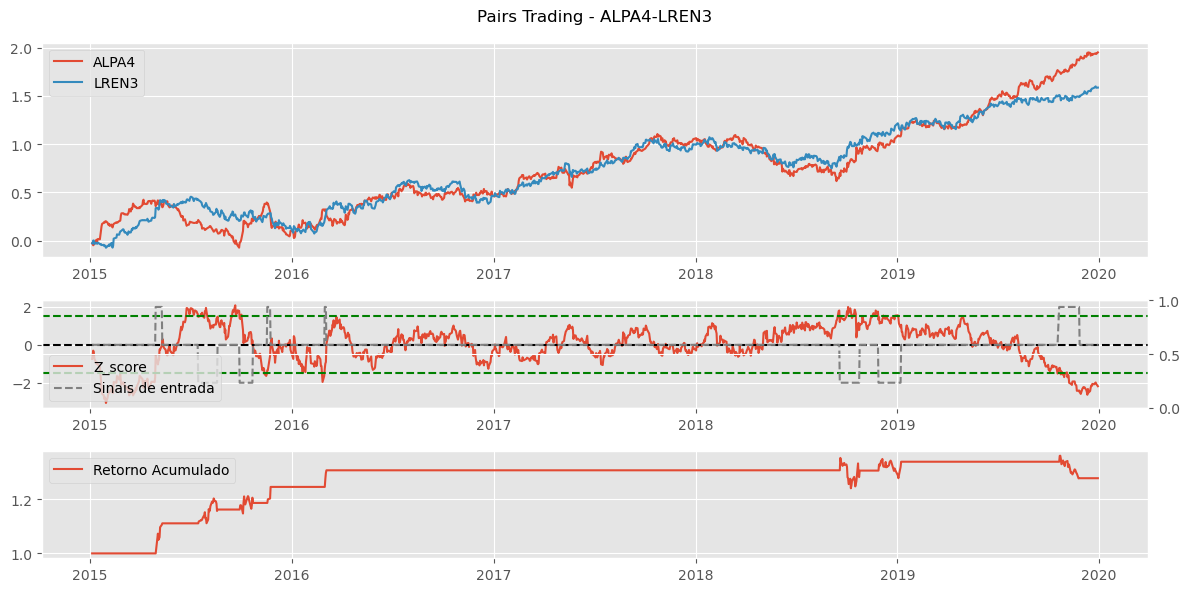

In [ ]:
fig = plt.figure(figsize=(12, 6))
grid = fig.add_gridspec(3, 1, height_ratios=[2, 1,1])

ax1 = fig.add_subplot(grid[0,0])

ax1.plot(train_data[pair_tickers[pairs_tag[0]]],label=pair_tickers[pairs_tag[0]])


ax2 = fig.add_subplot(grid[1,0])
ax2.plot(train_data.index,z_scores_train[pairs_tag[0]],label='Z_score')
ax2.axhline(0,color='black',linestyle='--')
ax2.axhline(SPREAD_LIMIT,color='green',linestyle='--')
ax2.axhline(-SPREAD_LIMIT,color='green',linestyle='--')
ax2.twinx()
ax2.plot(train_result[pairs_tag[0]][0].index,train_result[pairs_tag[0]][0]['signals']*2,color='gray',linestyle='--',label = "Sinais de entrada")

ax3 = fig.add_subplot(grid[2,0])
ax3.plot(train_result[pairs_tag[0]][0].index,train_result[pairs_tag[0]][0]['profits'].add(1).cumprod(),label='Retorno Acumulado')

ax1.legend()
ax2.legend(loc='lower left')
ax3.legend()

plt.suptitle(f'Pairs Trading - {pairs_tag[0]}')
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.savefig('Pairs_trading/images/Pairs_Trading.png')
plt.show()

Visualizando todos os Pares

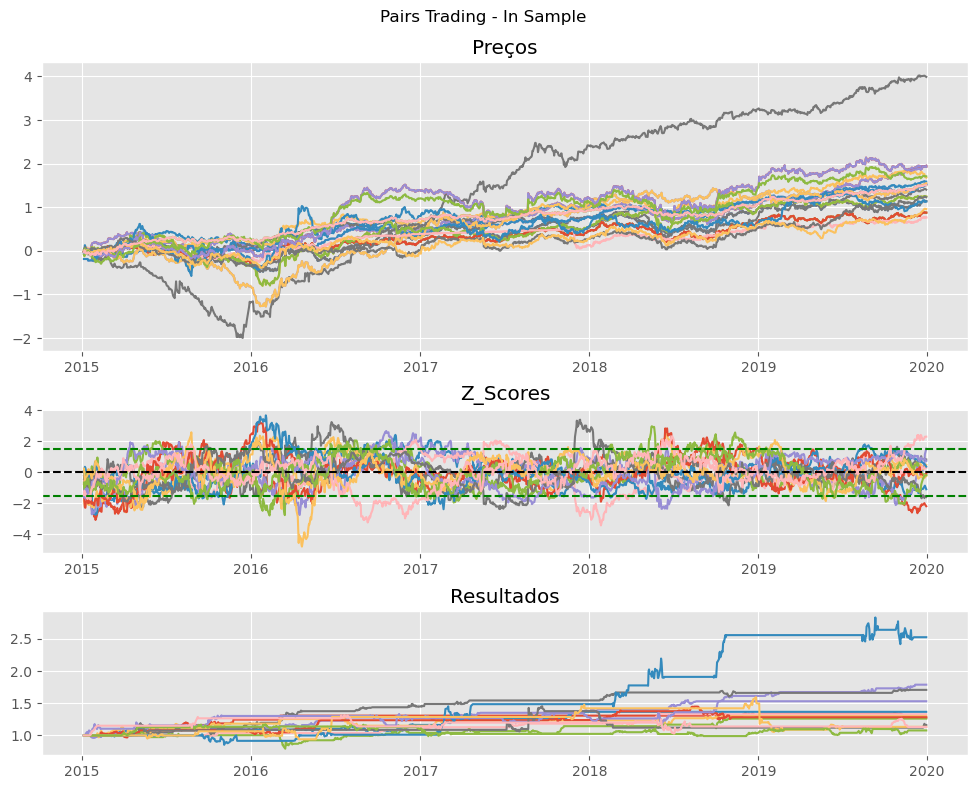

In [65]:
fig = plt.figure(figsize=(10, 8))
grid = fig.add_gridspec(3, 1, height_ratios=[3,1.5,1.5])
ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[1,0])
ax3 = fig.add_subplot(grid[2,0])
for pair in pairs_tag:
    ax1.plot(train_data[pair_tickers[pair]],label=train_data[pair_tickers[pair]].columns)
    ax2.plot(train_data.index,z_scores_train[pair],label=pair)
    ax3.plot(train_result[pair][0].index,train_result[pair][0]['profits'].add(1).cumprod(),label=pair)

ax2.axhline(0,color='black',linestyle='--')
ax2.axhline(SPREAD_LIMIT,color='green',linestyle='--')
ax2.axhline(-SPREAD_LIMIT,color='green',linestyle='--')

ax1.set_title('Preços')
ax2.set_title('Z_Scores')
ax3.set_title('Resultados')
plt.suptitle(f'Pairs Trading - In Sample')
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

Calculo para os dados de treino

In [66]:
test_result = {}
for pair in tqdm(pairs_tag):
    df_test_strategie, df_trades = fn_pairs_trading(test_data_price[pair_tickers[pair]],
                                                                   test_data[pair_tickers[pair]],
                                                                   z_scores_test[pair],
                                                                    CAIXA,SPREAD_LIMIT,MAX_DAYS,PCT_ORDEM1,PCT_ORDEM2[pair])
    test_result[pair] = [df_test_strategie]
    



100%|██████████| 14/14 [00:00<00:00, 18.54it/s]


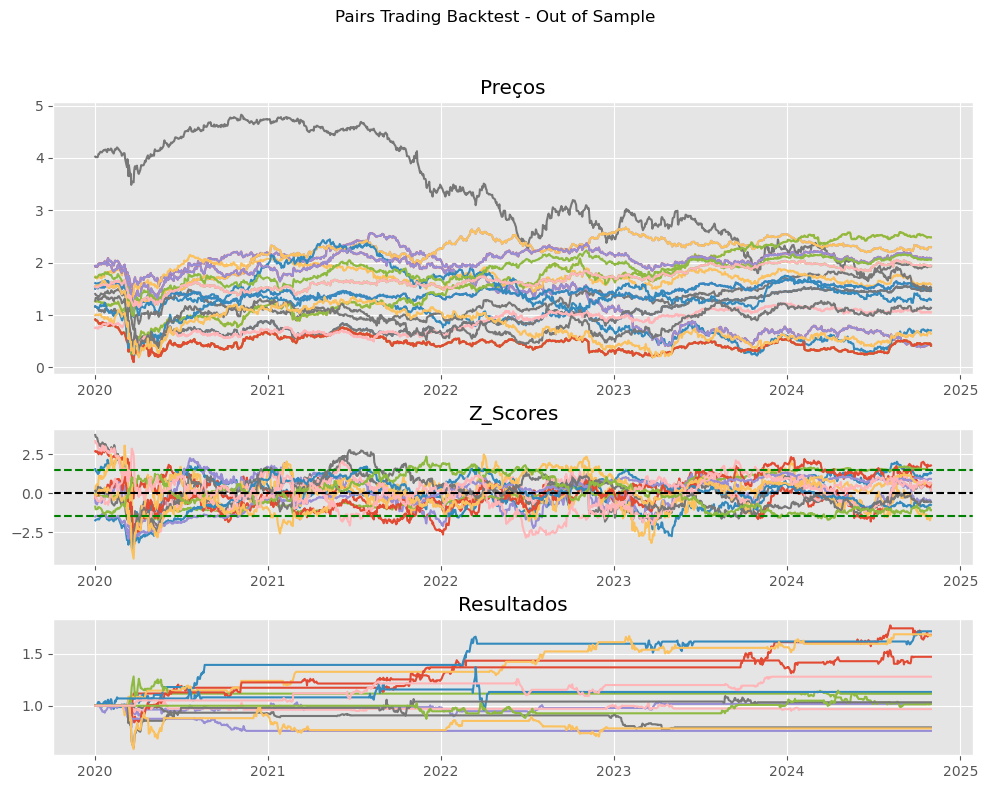

In [67]:
fig = plt.figure(figsize=(10, 8))
grid = fig.add_gridspec(3, 1, height_ratios=[3, 1.5,1.5])
ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[1,0])
ax3 = fig.add_subplot(grid[2,0])
for pair in pairs_tag:
    ax1.plot(test_data[pair_tickers[pair]],label=test_data[pair_tickers[pair]].columns)
    ax2.plot(test_data.index,z_scores_test[pair],label=pair)
    ax3.plot(test_result[pair][0].index,test_result[pair][0]['profits'].add(1).cumprod(),label=pair)

ax2.axhline(0,color='black',linestyle='--')
ax2.axhline(SPREAD_LIMIT,color='green',linestyle='--')
ax2.axhline(-SPREAD_LIMIT,color='green',linestyle='--')

ax1.set_title('Preços')
ax2.set_title('Z_Scores')
ax3.set_title('Resultados')
plt.suptitle(f'Pairs Trading Backtest - Out of Sample')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

Calculando resultados para Treino (**In-Sample**) e Teste (**Out-of-Sample**) para comparação

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 3072.75it/s]


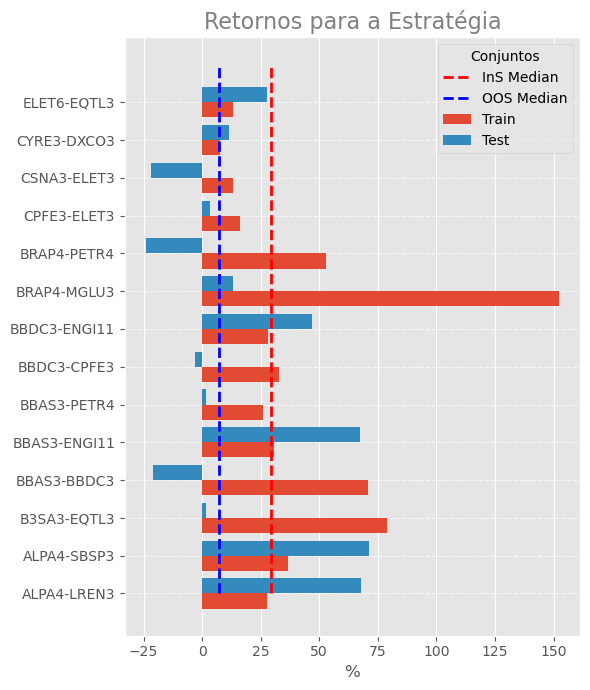

A mediana dos retornos para os dados de In-Sample é :29.53
A mediana dos retornos para os dados de Out-of-Sample é :7.41


In [68]:
gain_pct_train = {}
gain_pct_test = {}
for tag in tqdm(pairs_tag):
    gain_pct_train[tag] = ((train_result[tag][0]['net_value'].iloc[-1] / train_result[tag][0]['net_value'].iloc[0])-1)*100
    gain_pct_test[tag] = ((test_result[tag][0]['net_value'].iloc[-1] / test_result[tag][0]['net_value'].iloc[0])-1)*100
df_gains = pd.DataFrame({'Resultados-InS':list(gain_pct_train.values()),'Resultados-OOS':list(gain_pct_test.values())},index=pairs_tag)


x = np.arange(len(df_gains.index))
width = 0.4  

# Criação da figura
plt.figure(figsize=(6, 7))
# Barras para Resultados-InS
plt.barh(x - width / 2, df_gains['Resultados-InS'], width, label='Train')
plt.vlines(x=(df_gains['Resultados-InS'].median()),ymax=len(df_gains),ymin=0,linestyles='--',linewidth=2,label='InS Median',color='r')
plt.vlines(x=(df_gains['Resultados-OOS'].median()),ymax=len(df_gains),ymin=0,linestyles='--',linewidth=2,label='OOS Median',color='blue')

# Barras para Resultados-OOS
plt.barh(x + width / 2, df_gains['Resultados-OOS'], width, label='Test',)

# Configuração dos rótulos do eixo x
plt.yticks(x, df_gains.index)

plt.xlabel('%')
plt.title('Retornos para a Estratégia', size=16, color='gray')
plt.legend(title='Conjuntos')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

print(f'A mediana dos retornos para os dados de In-Sample é :{np.round(df_gains['Resultados-InS'].median(),2)}')
print(f'A mediana dos retornos para os dados de Out-of-Sample é :{np.round(df_gains['Resultados-OOS'].median(),2)}')

O **Long & Short (Pairs Trading)** por cointegração é uma estratégia amplamente utilizada e testada no mercado financeiro. No entanto, é fundamental considerar algumas limitações e hipóteses que podem impactar sua eficácia:

### Considerações sobre a estratégia:

- **Alteração na Cointegração e Correlação**:  
   A relação de cointegração e correlação entre os ativos pode se modificar ao longo do tempo devido a mudanças nas condições de mercado, fatores econômicos, eventos corporativos ou alterações na dinâmica de oferta e demanda. Isso pode comprometer a estabilidade do modelo utilizado.

- **Eficácia Estatística**:  
   A identificação de cointegração entre os ativos baseia-se em métodos estatísticos, como o teste **ADF**, que possuem margens de erro. Falsos positivos (identificação de cointegração onde não existe) podem levar a operações que não seguem o comportamento esperado.

- **Impactos de Custos Operacionais**:  
   Custos de corretagem, taxas e impostos não são frequentemente incorporados nos modelos teóricos, mas impactam significativamente os resultados quando a estratégia é aplicada na prática.

- **Riscos de Ruído de Mercado**:  
   Movimentos aleatórios e eventos inesperados podem levar a divergências no spread que não retornam à média histórica, resultando em prejuízos.

- **Necessidade de Ajustes Constantes**:  
   A estratégia exige acompanhamento e ajustes regulares para garantir que os pares cointegrados ainda sejam válidos e que o modelo permaneça calibrado frente às mudanças do mercado.

- **Diversificação Insuficiente**:  
   Dependendo do número de pares utilizados, a estratégia pode não ser suficientemente diversificada, aumentando o risco específico de cada par.

- **Períodos de Baixa Volatilidade ou Alta Correlação Geral**:  
   Em períodos de baixa volatilidade ou alta correlação entre muitos ativos (como durante crises financeiras), a estratégia pode encontrar menos oportunidades de arbitragem, reduzindo sua eficácia.

- **Riscos de Liquidez**:  
   A execução de operações em ativos com baixa liquidez pode resultar em slippage elevado e dificuldade para encerrar posições, afetando os resultados.

### Conclusão:
Embora o **Pairs Trading** por cointegração seja uma estratégia robusta e amplamente estudada, sua aplicação prática requer uma análise cuidadosa e uma abordagem adaptável às condições de mercado. Incorporar monitoramento contínuo, custos operacionais, e ajustar os parâmetros da estratégia são passos essenciais para mitigar os riscos associados.  
